<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC4</p>
<p style="margin: 0; text-align:right;">2020-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicacions</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 4: Regresió i Combinació de classificadors

Aquesta pràctica està dividida en dues parts:

 - En el primer exercici aplicarem diferents models de regresió en diferents conjunts de dades.
 - En el segon exercici estudiarem diferents tecniques mitjançant les que podrem combinar el resultat de múltiples classificadors. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nom i cognoms:</strong>
</div>

Jordi Montserrat (posa el que tu vulguis aquí)

Per aquesta PAC es poden utilitzar **únicament les llibreries que s'importen a continuació**. Si es desitja utilitzar una altre llibreria s'ha de consultar amb el tutor/tutora de l'aula.

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

%matplotlib inline

# 1. Regresió (5 punts)

A la primera part d'aquest exercici analitzarem els resultats de diferents models de regresió aplicats a tres conjunts de dades sintètiques amb els que veurem les seves fortaleses i les seves debilitats.

A la segona part aplicarem el model que considerem més oportú a un problema de la vida real.

## 1.1. Conjunts de dades sintètiques

Generarem tres conjunts de dades amb un únic atribut descriptiu que utilitzarem per predir el valor de la variable depenent, podent així visualitzar en dos dimensions el comportament de cada model.

Per altre banda, en els problemes de regresió podem trobar dos tipus de problemàtiques diferents: **interpolació** (la predicció es realitzarà en base a atributs descriptius dins d'un interval conegut) i **extrapolació** (algun dels seus atributs descriptius pren valors fora del rang de valors vist per l'algorisme durant l'etapa d'aprenentatge).

Com que només disposem d'un atribut descriptiu, posarem un umbral en aquest atribut per diferenciar el que seria interpolació (marcat en blau) del que seria extrapolació (marcat en vermell). La gran diferència entre aquests dos subconjunts de dades és que, mentres que part de les dades que interpolem les utilitzarem per entrenar, cap dada de les que extrapolem serà utilitzada en l'etapa d'aprenentatge.

El següent codi genera i mostra els tres conjunts de dades:

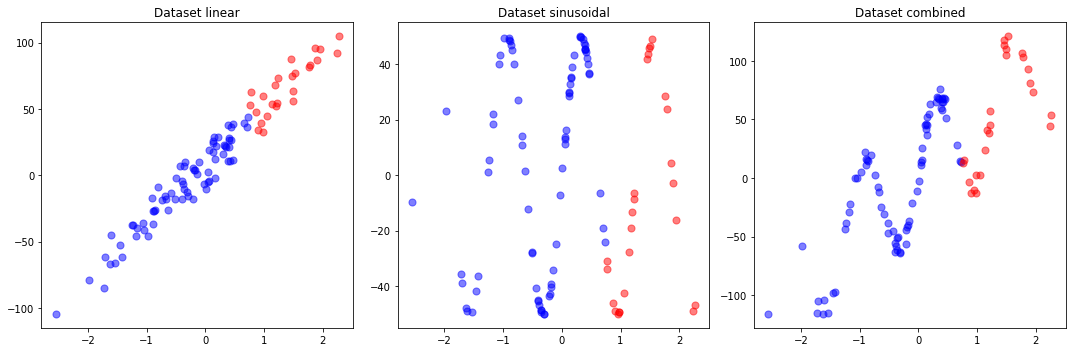

In [58]:
# Cada variable (linial, sinusoidal i combined) serà una tupla amb cinc posicions:
# el nombre del dataset i els dos valors X i y tant per casos d'interpolació como d'extrapolació.
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=9, noise=9, random_state=0)
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_linear = ('linear', X[:75], y[:75], X[-25:], y[-25:])
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=5, noise=5, random_state=0)
y = (50*np.sin(5*X)).ravel()
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_sinusoidal = ('sinusoidal', X[:75], y[:75], X[-25:], y[-25:])
X, y = datasets.make_regression(n_features=1, n_samples=100, bias=5, noise=5, random_state=0)
y += (50*np.sin(5*X)).ravel()
X, y = zip(*sorted(zip(X,y)))
X = np.array(X); y = np.array(y)
data_combined = ('combined', X[:75], y[:75], X[-25:], y[-25:])

# Guardem tots els datasets en una tupla.
datasets_tuple = (data_linear, data_sinusoidal, data_combined)

# I mostrem la seva distribució bidimensional
fig, axis = plt.subplots(1, 3, figsize=(15,5))
for dataset, ax in zip(datasets_tuple, axis):
    ax.scatter(dataset[1], dataset[2], alpha=0.5, color='b', s=50, marker='o')
    ax.scatter(dataset[3], dataset[4], alpha=0.5, color='r', s=50, marker='o')
    ax.set_title('Dataset {}'.format(dataset[0]))

plt.tight_layout()

In [59]:
from sklearn.metrics import make_scorer, precision_score, recall_score

# create a dict of standard models to evaluate {name:object}
def get_models():
    models=dict()
    # linear models
    models['lr'] = LinearRegression()
    models['svr'] = SVR()
    models['dt'] = DecisionTreeRegressor()
    models['knn'] = KNeighborsRegressor()
    return models


# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline


# Define a function for model evaluation using cross validation
def evaluate_model_cross_validation(name, model, X_train, y_train, folds = 10, 
                                    response='regression'):
    
    pipeline = make_pipeline(model)
    
    if response == 'regression':
        metrics = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error',
                  'R2': 'r2'}
    elif response == 'classification':
        metrics = {'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted'), 
                   'acc-score': 'accuracy'}
    
    for metric in metrics:
        print(f"\nEvaluating {metric}:\n")
        scores = cross_val_score(pipeline, X_train, y_train, scoring=metrics[metric], 
                                 cv=folds, n_jobs=-1)
        print(f"{metric} Scores are:\n", scores)
        mean_score, std_score = np.mean(scores), np.std(scores)
        print(f'>%s - training - {metric}: %.3f (+/-%.3f)' % (name, mean_score, std_score))


In [60]:
def eval_and_plot_cv_score(model, X_train, y_train, metric, folds = 10, 
                           response='regression'):
    
    print(f"Using metric {metric} and model {model}")
    
    metrics = {'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error',
              'R2': 'r2', 'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'), 
               'accuracy': 'accuracy'}
    
    if response == 'regression':
        assert metric in ['MAE', 'MSE', 'R2'], "Metric should be one of MAE, MSE, R2"
    
    elif response == 'classification':
        assert metric in ['precision', 'recall', 'accuracy'], "Metric should be one of precision, recall, accuracy"
    else:
        raise NotImplementedError("Response not implemented use one of regression or classification")
    
    pipeline = make_pipeline(model)
    
    scores = cross_val_score(pipeline, X_train, y_train, scoring=metrics[metric], cv=folds, n_jobs=-1)
    mean_score, std_score = np.mean(scores), np.std(scores)
    
    return mean_score, std_score

    
        


In [61]:
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

def model_trainer(model, X_train, y_train, scaler=None):
    '''Scales and Trains the data. If scaler is None it asumes data is already scaled'''
    if scaler is not None:
        try:
            check_is_fitted(scaler)
        except NotFittedError:
            print("Scaler not fitted. Fit and train the scaler and model")
            X_train = scaler.fit_transform(X_train)
    
        model.fit(X_train, y_train)
    
        return model, scaler
    else:
        model.fit(X_train, y_train)
    
        return model, None
            

Amb l'objectiu de mostrar les capacitats de cadascuna de les tècniques de regresió sobre els tres conjunts de dades generats, es facilita la següent funció que, donat un model, l'entrena per després mostrar els resultats obtinguts, tan en els casos d'interpolació com els d'extrapolació.

In [62]:
def plot_regressor_performance(reg):
    fig, axis = plt.subplots(1, 3, figsize=(15,5))
    for dataset, ax in zip(datasets_tuple, axis):
        reg.fit(dataset[1], dataset[2])
        print(f'Dataset {dataset[0]}, '
              f'score interpolation: {reg.score(dataset[1], dataset[2])}, '
              f'score extrapolation: {reg.score(dataset[3], dataset[4])}')

        X_interpolation = np.linspace(
            np.min(dataset[1]), np.mean(np.array([np.max(dataset[1]), np.min(dataset[3])])), 7500
        ).reshape(-1, 1)
        X_extrapolation = np.linspace(
            np.mean(np.array([np.max(dataset[1]), np.min(dataset[3])])), np.max(dataset[3]), 2500
        ).reshape(-1, 1)
        
        ax.plot(X_interpolation, reg.predict(X_interpolation), color='b', linewidth=3)
        ax.scatter(dataset[1], dataset[2], alpha=0.25, color='b', s=100, marker='o')
        ax.plot(X_extrapolation, reg.predict(X_extrapolation), color='r', linewidth=3)
        ax.scatter(dataset[3], dataset[4], alpha=0.25, s=100, color='r')
        ax.set_title(f'Dataset {dataset[0]}')
    
    plt.tight_layout()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>
    
Amb l'ajuda de la funció *plot_regressor_performance* que acabem de definir, analitza el comportament de cadascuna de les següents tècniques:
- regresió linial
- knn
- svm
- àrbre de decisió


<u>Suggerència</u>: pots trobar la documentació dels models de regresió que has d'utilitzar en els següents enllaços:
- LinearRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- KNeighborsRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
- SVR: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
- DecisionTreeRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
</div>

Running model lr
Dataset linear, score interpolation: 0.9141115687129225, score extrapolation: 0.7480861816554351
Dataset sinusoidal, score interpolation: 0.09687072757724613, score extrapolation: -1.4489455436255243
Dataset combined, score interpolation: 0.585078624067839, score extrapolation: -0.5169205593597506
Running model svr
Dataset linear, score interpolation: 0.4971483839350117, score extrapolation: -12.38567142640009
Dataset sinusoidal, score interpolation: 0.10289729257219382, score extrapolation: -0.7054925398584895
Dataset combined, score interpolation: 0.22424838318873674, score extrapolation: -1.279542986466057
Running model dt
Dataset linear, score interpolation: 1.0, score extrapolation: -1.3458417109611087
Dataset sinusoidal, score interpolation: 1.0, score extrapolation: -0.15418002495961636
Dataset combined, score interpolation: 1.0, score extrapolation: -0.7313473636504104
Running model knn
Dataset linear, score interpolation: 0.9144613698009034, score extrapolatio

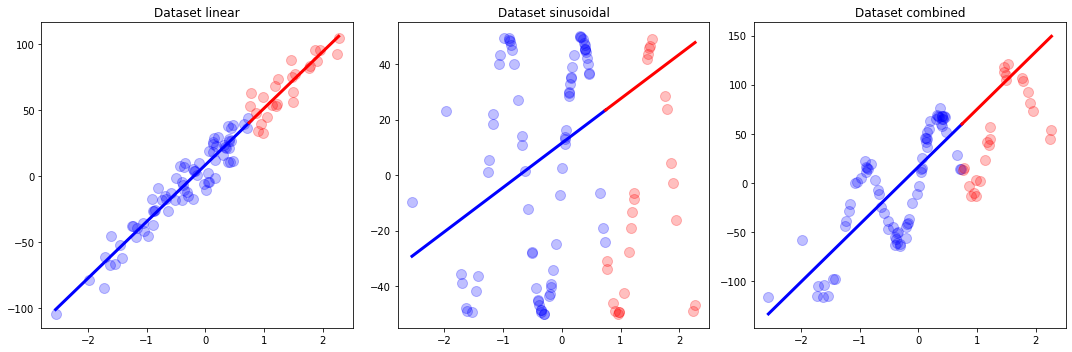

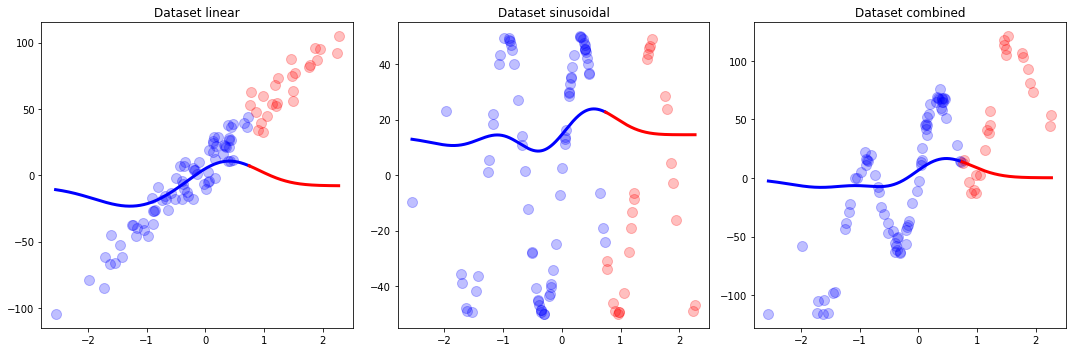

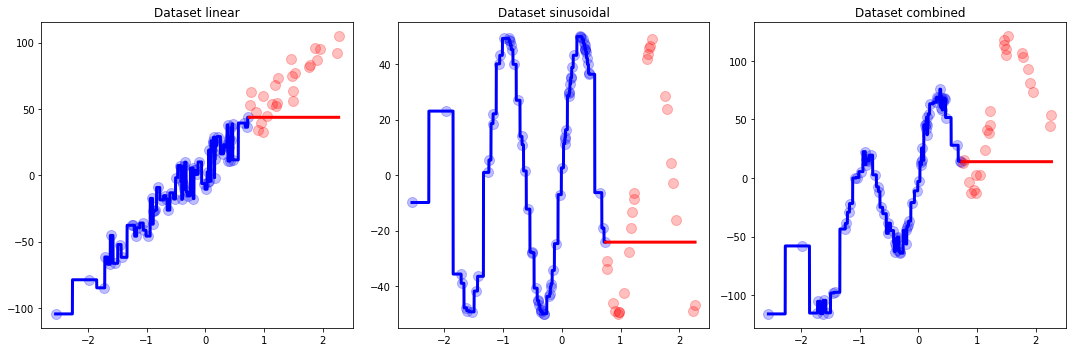

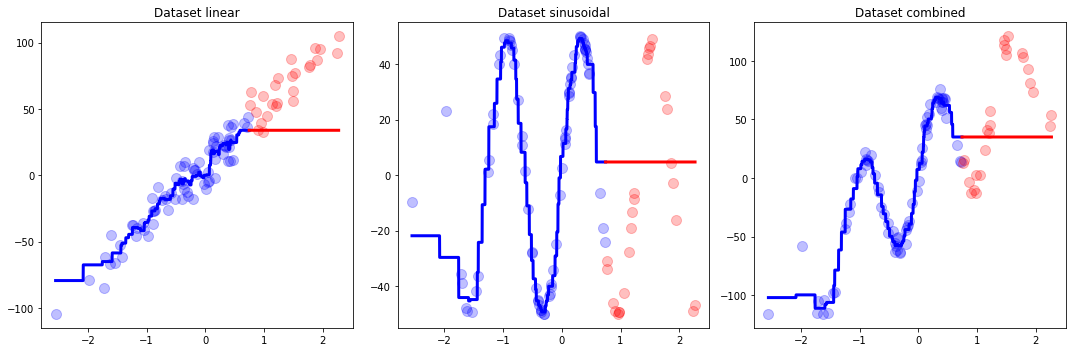

In [63]:
models = get_models()

for model in models:
    print(f"Running model {model}")
    plot_regressor_performance(models[model])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Com es comporta cada model de regresió? Quins models extrapolen?
</div>

El model que extrapola sería la regressió lineal per al conjunt de dades linear i la màquina de vector support per a les dades sinusoidals.
Si analitzem el comportament dels models per a les dades de train, l'arbre de decisió i els n veins més propers són els que fan la interpolació perfecte de les dades.

## 1.2 Conjunt de dades reals

### Buscant "chollos" a Taiwan

En aquest cas pràctic utilitzarem un conjunt de dades públic de preus de vivendes a Taiwan amb l'objectiu de trobar les millors ofertes del mercat. La descripció completa del conjunt de dades la podem trobar en el següent enllaç:  https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Comencem carregant les dades en un DataFrame de pandas:

In [64]:
# !pip install openpyxl
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


La primera columna ("*No*") és un identificador numèric de la mostra. Les columnes "*Xn ...*" són els diferents atributs descriptius. Finalment, la columna "*Y ...*" és el valor objetiu o preu de la vivenda.

Extraiem del *DataFrame* la variable objetiu i els atributs descriptius que utilitzarem posteriorment al model predictiu:

In [65]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>
    
És el moment d'analitzar quina pinta tenen les dades, per aquest motiu genera:
  - Els histogrames de cada atribut descriptiu
  - Gràfiques que relacionin cadascun d'ells amb la variable objectiu (scatterplots)

<u>Suggerència</u>: També pot resultar útil observar la distribució geoespacial dels preus.
</div>

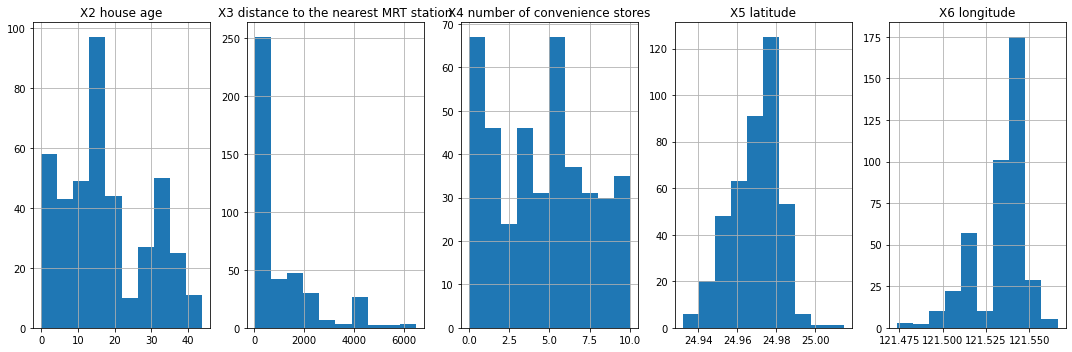

In [66]:
def plot_histograms(data):
    fig, axis = plt.subplots(1, 5, figsize=(15,5))
    for column, ax in zip(data, axis):
        
        data.hist(column=column, ax=ax)
    
    plt.tight_layout()

plot_histograms(X)

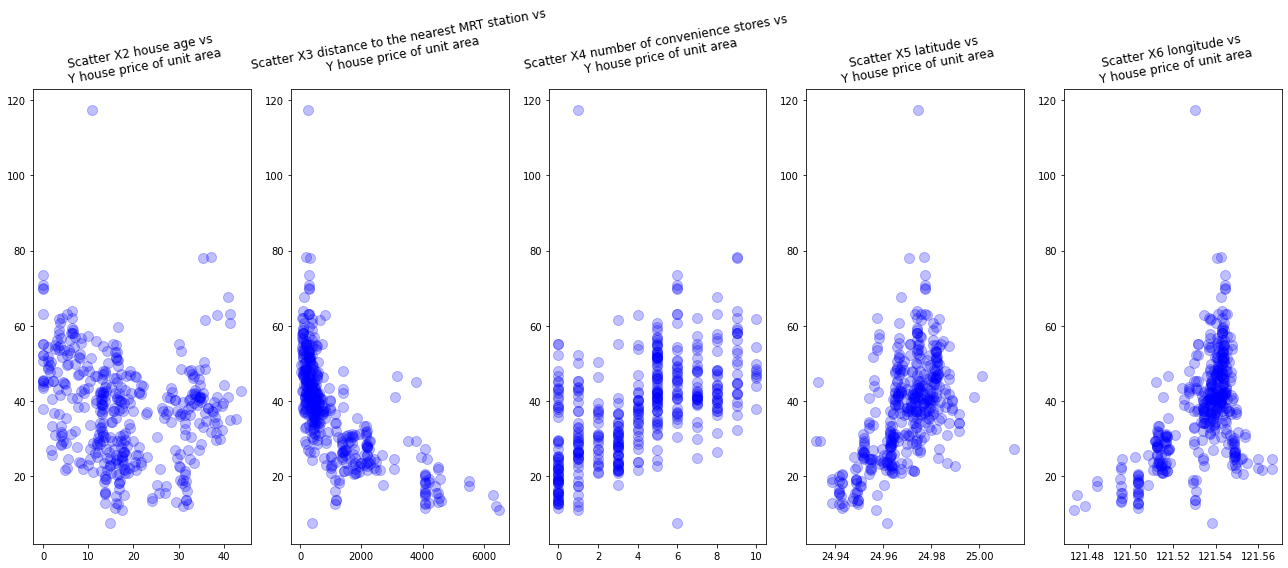

In [67]:
def plot_scatter(data, y):
    fig, axis = plt.subplots(1, 5, figsize=(18,8))
    for column, ax in zip(data, axis):
        
        ax.scatter(data[column], y, alpha=0.25, s=100, color='b')
        ax.set_title(f'Scatter {column} vs\n {y.name}', rotation = 10)
    
    plt.tight_layout()

plot_scatter(X, y)

In [68]:
dataset.corr(method ='pearson')

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,1.000000,-0.048634,-0.032808,-0.013573,-0.012699,-0.010110,-0.011059,-0.028587
X1 transaction date,-0.048634,1.000000,0.017542,0.060880,0.009544,0.035016,-0.041065,0.087529
X2 house age,-0.032808,0.017542,1.000000,0.025622,0.049593,0.054420,-0.048520,-0.210567
X3 distance to the nearest MRT station,-0.013573,0.060880,0.025622,1.000000,-0.602519,-0.591067,-0.806317,-0.673613
X4 number of convenience stores,-0.012699,0.009544,0.049593,-0.602519,1.000000,0.444143,0.449099,0.571005
X5 latitude,-0.010110,0.035016,0.054420,-0.591067,0.444143,1.000000,0.412924,0.546307
X6 longitude,-0.011059,-0.041065,-0.048520,-0.806317,0.449099,0.412924,1.000000,0.523287
Y house price of unit area,-0.028587,0.087529,-0.210567,-0.673613,0.571005,0.546307,0.523287,1.000000


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Què pots deduir de les gràfiques obtingudes?
</div>

Existeix relació lineal entre la variable resposta i les variables latitud i longitud mentre que 
existeix una relació lineal inversa entre la variable resposta i la variable distance to the 
nearest MRT station.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>

Amb el coneixement adquirit a l'apartat 1.1 i tenint en compte les distribucions de les dades que acabem d'observar, escull la tècnica de regresió que creguis que s'ajusta millor al problema que volem resoldre.

Divideix el conjunt de dades original en train i test i aplica la tècnica escollida.
</div>

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, random_state = 0)

In [70]:
model_trained = dict()
for model in models:
    print(f"Using model {model}")
    evaluate_model_cross_validation("Model Selection", models[model], X_train, y_train, folds = 10,
                                   response='regression')

Using model lr

Evaluating MAE:

MAE Scores are:
 [-7.33473601 -5.46645133 -5.9547795  -5.40738478 -5.97827717 -5.67534311
 -8.19266241 -6.81875074 -7.55377074 -5.91252002]
>Model Selection - training - MAE: -6.429 (+/-0.926)

Evaluating MSE:

MSE Scores are:
 [-113.17315224  -48.03102245  -64.39677128  -54.30246984  -64.66832108
  -50.45586835 -233.4826798   -87.03744713  -92.44388415  -59.2281415 ]
>Model Selection - training - MSE: -86.722 (+/-52.797)

Evaluating R2:

R2 Scores are:
 [0.37524387 0.58095534 0.67061227 0.69516502 0.66172276 0.71446442
 0.32653715 0.41262898 0.41798655 0.6030646 ]
>Model Selection - training - R2: 0.546 (+/-0.140)
Using model svr

Evaluating MAE:

MAE Scores are:
 [-6.12462585 -4.2276539  -5.72153538 -5.14876848 -5.24289631 -5.35125169
 -6.70560062 -5.72605133 -6.70326629 -5.90044185]
>Model Selection - training - MAE: -5.685 (+/-0.710)

Evaluating MSE:

MSE Scores are:
 [-108.8807914   -32.72217254  -61.62347687  -57.71139776  -60.22486318
  -54.68245

In [71]:
scaler = StandardScaler()
knn = KNeighborsRegressor()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
knn.fit(X_train_sc, y_train)

KNeighborsRegressor()

In [72]:
# Opció 2. Esborra el que hi ha a dalt i utilitza aquesta funcion en comptes
knn, scaler = model_trainer(KNeighborsRegressor(), X_train, y_train, scaler=StandardScaler())

Scaler not fitted. Fit and train the scaler and model


In [73]:
X_test_sc = scaler.transform(X_test)
predicted = knn.predict(X_test_sc)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Per què has escollit aquesta tècnica? Què tal es comporta?
</div>

La técnica que presenta uns resultats més satisfactoris es el KNN, degut a que es basa en els n veins mes propers i, el problema analitzat fa referéncia al preu de les vivendes a Taiwan. Si analitzem les variables i la seva importància en vers les dades, podem observar que la latitud, longitud i distància a una estació de MRT son les variables més rellevants. Per aquest motiu l'ús d'un KNN ens ha semblat la metodología més adient.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>

És el moment d'aplicar el model que has entrenat amb el subconjunt de train per buscar "chollos" en el subconjunt de test.

<u>Suggerència</u>: Calcula la diferència entre el valor predit i el valor real del preu de cada vivenda del subconjunt de test per trobar les vivendes més interessants del mercat.
</div>

In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MAE", mean_absolute_error(y_test, predicted))
print("MSE", mean_squared_error(y_test, predicted))

MAE 5.419518072289157
MSE 57.31026024096386


In [75]:
results = pd.DataFrame.from_dict(
    {'Real': y_test.values.tolist(), 'Predicted': predicted.tolist(), 
     'Difference': (y_test.values - predicted).tolist()})
results.index = y_test.index
print(results.sort_values(by=['Difference']).head())

     Real  Predicted  Difference
402  28.5      50.02      -21.52
271  26.5      43.72      -17.22
145  45.5      61.42      -15.92
334  22.8      35.50      -12.70
199  31.6      43.50      -11.90


# 2. Combinació de classificadors (5 punts)

En aquest exercici utilitzarem un subconjunt de 5.000 imatges provinents del corpus EMINST, constituit per caràcters i dígits escrits a ma. Aquest subconjunt està format per 1.000 imatges per a cadascuna de les 5 classes (lletres) diferents ("A", "B", "C", "D" i "E").

A la primera part d'aquest exercici veurem la combinació de classificadors en paral·lel mitjançant les tècniques de **Bagging** i **Boosting**.

La segona part pretén millorar els resultats aplicant tècniques de combinació seqüencial de classificadors: **Stacking** y **Cascading**.

Per començar, anem a visualitzar el dataset. Les imatges tenen una resolució de 28x28 píxels en escala de grisos, fet pel qual es poden representar utilitzant un vector de 784 posicions. El següent codi carregarà les 5.000 imatges en la variable *images* i les etiquetes corresponents (en forma numèrica) en la variable *labels*. Podem comprovar que la càrrega ha estat correcte obtenint les dimensions d'aquestes dues variables.

In [76]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["A", "B", "C", "D", "E"]

print("Dimensiones del vector de imágenes: {}".format(images.shape))
print("Dimensiones del vector de etiquetas: {}".format(labels.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Amb el següent codi podem veure un exemple d'imatge de cadascuna de les classes. Per tal de poder mostrar les imatges, reajustem el vector de 784 dimensions que representa cada imatge a una matriu de tamany 28x28 i la transposem. 

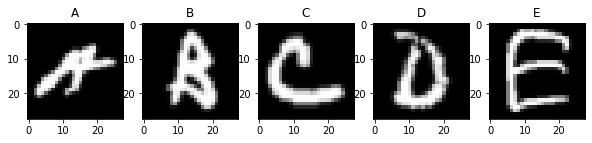

In [77]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

Per poder provar varis models, primer dividirem el dataset en train i test.

La divisió amb la funció *train_test_split* és aleatòria, però perquè tots obtingueu els mateixos resultats i poder comentar dubtes pel fòrum, fixarem la seed per obtenir els mateixos datasets de train i test. El *split* tindrà en compte que els dos conjunts tinguin el mateix nombre d'exemples per cadascuna de les classes gràcies al paràmetre *stratify=labels*.

Com que en la segona part d'aquest exercici tractarem *stacking* i *cascading*, i ambdos s'apliquen sobre el conjunt de test, farem un *split* del 50% per tenir una mica més de base a l'aplicar aquestes dues tècniques.

In [78]:
myseed = 13

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5,
                                                    random_state=myseed, 
                                                    stratify=labels)

In [79]:
# Scale x features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## 2.1. Combinació paral·lela de classificadors

### 2.1.1. Arbre de decisió

Per poder comparar l'augment de performance obtingut a mida que anem aplicant tècniques noves, utilitzarem com a *baseline* un simple arbre de decisió.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>
    
Evalua la precisió d'un arbre de decisió amb profunditat màxima de 5 nivells (aplicarem la mateixa restricció en les següents seccions) aplicant validació creuada sobre el conjunt de dades de train.
    
A continuació, entrena el mateix model sobre el conjunt de train, calcula i guarda les prediccions sobre el conjunt de test i calcula la precisió en el conjunt de test.
       
<u>Suggerència</u>: utilitzar el mòdul *cross_val_score* de sklearn. Per apendre més sobre *cross validation* i sobre com utilitzar aquests mòduls, us recomanem els següents enllaços: 
- http://scikit-learn.org/stable/modules/cross_validation.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

In [80]:
model = DecisionTreeClassifier(max_depth=5)
evaluate_model_cross_validation("Dec Tree Classifier", model, X_train, y_train, folds = 10,
                               response='classification')


Evaluating precision:

precision Scores are:
 [0.82536281 0.75114804 0.81691836 0.77005942 0.79437108 0.81907817
 0.75172876 0.83897597 0.78259081 0.8164062 ]
>Dec Tree Classifier - training - precision: 0.797 (+/-0.030)

Evaluating recall:

recall Scores are:
 [0.804 0.744 0.816 0.768 0.784 0.808 0.752 0.836 0.78  0.816]
>Dec Tree Classifier - training - recall: 0.791 (+/-0.029)

Evaluating acc-score:

acc-score Scores are:
 [0.816 0.748 0.816 0.764 0.792 0.816 0.744 0.84  0.784 0.816]
>Dec Tree Classifier - training - acc-score: 0.794 (+/-0.031)


In [81]:
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train_sc, y_train)

DecisionTreeClassifier(max_depth=5)

In [82]:
# Opció 2. Esborra el que hi ha a dalt i utilitza aquesta funcion en comptes
dtc, _ = model_trainer(DecisionTreeClassifier(max_depth=5), X_train_sc, y_train)

In [83]:
predicted = dtc.predict(X_test_sc)

In [84]:
from sklearn.metrics import precision_score
print("precision", precision_score(y_test, predicted, average='weighted'))
print("accuracy score", accuracy_score(y_test, predicted))

precision 0.8009545025579459
accuracy score 0.7952


### 2.1.2.a Bagging

La idea bàsica del bagging és utilitzar el conjunt d'entrenament original per generar centenar o milers de conjunts similars utilitzant mostreig amb remplaçament. L'algorisme random forest està basat en aquest concepte, la combinació de varis arbres de decisió, cadascun entrenat amb una mostra diferent de les dades. La decisió final del classificador combinat (la random forest) es pren per majoria, donant el mateix pes a totes les decisions parcials preses pels classificadors base (els arbres).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
        
Evalua la precisió d'un <i>random forest</i> combinat amb 20 arbres de decisió amb profunditat màxima de 5 nivells aplicant validació creuada sobre el conjunt de dades de train.

A continuació, entrena el mateix model sobre el conjunt de train, calcula i guarda les prediccions sobre el conjunt de test i calcula la precisió en el conjunt de test.
    
<u>Suggerència</u>: utilitzar el mòdul *RandomForestClassifier* de *sklearn*. Para aprendre a utilitzar aquest mòdul recomanem el següent enllaç:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

In [85]:
model = RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1)
evaluate_model_cross_validation("RForest Classifier", 
                                model, X_train, y_train, folds = 10,
                               response='classification')


Evaluating precision:

precision Scores are:
 [0.9222276  0.84261047 0.8675597  0.86426874 0.90560955 0.92006214
 0.87794536 0.90432791 0.8987147  0.8920813 ]
>RForest Classifier - training - precision: 0.890 (+/-0.025)

Evaluating recall:

recall Scores are:
 [0.916 0.864 0.876 0.88  0.876 0.904 0.856 0.916 0.888 0.904]
>RForest Classifier - training - recall: 0.888 (+/-0.020)

Evaluating acc-score:

acc-score Scores are:
 [0.924 0.876 0.864 0.856 0.92  0.932 0.864 0.872 0.848 0.888]
>RForest Classifier - training - acc-score: 0.884 (+/-0.029)


In [86]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1)
rfc.fit(X_train_sc, y_train)

RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1)

In [87]:
# Opció 2. Esborra el que hi ha a dalt i utilitza aquesta funcion en comptes
rfc, _ = model_trainer(RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1), X_train_sc, y_train)

In [88]:
predicted = rfc.predict(X_test_sc)

In [89]:
from sklearn.metrics import precision_score
print("precision", precision_score(y_test, predicted, average='weighted'))
print("accuracy score", accuracy_score(y_test, predicted))

precision 0.880290561895308
accuracy score 0.8788


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Han millorat els resultats respecte a un simple arbre de decisió? Era d'esperar?
</div>

Si, els resultats milloren degut a la combinació de diferents arbres de decisió. També degut a que cadascun dels arbres de decisió ha estat entrenat amb una mostra diferent de les dades.

### 2.1.2.b. Out-of-bag

Un aventatge del *bagging* utilitzat en el *Random Forest* és que cadascun dels arbres de decisió ha estat entrenat amb una combinació diferent de les dades (motstreig amb remplaçament), és a dir, cadascun dels arbres no ha vist una determinada part de les dades originals. Això defineix una espècie de conjunt de test per cadascun dels arbres, anomenat *out-of-bag*, que es pot utilitzar per estimar l'error del model sense necessitat d'utilitzar el conjunt de test real que hem creat previament, ni d'utilitzar estratègies de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>
    
Entrena sobre el conjunt de train un model de <i>random forest</i> combinat amb 20 arbres de decisió amb profunditat màxima de 5 nivells i mostra la precisió d'aquest model en el *out-of-bag*.
    
<u>Suggerència</u>: utilitzar el mòdul *RandomForestClassifier* de *sklearn*. Per apendre més sobre *out-of-bag* i com utilitzar aquest mòdul (incloent l'atribut *oob&#95;score_*), us recomanem els següents enllaços:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

</div>

In [90]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1, oob_score=True)
rfc.fit(X_train_sc, y_train)

RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1, oob_score=True)

In [91]:
# Opció 2. Esborra el que hi ha a dalt i utilitza aquesta funcion en comptes
rfc, _ = model_trainer(RandomForestClassifier(max_depth=5, n_estimators=20, n_jobs=-1, oob_score=True),
                       X_train_sc, y_train)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> La precisió obtinguda en el <i>out-of-bag</i> i amb els mètodes de validació anteriors són comparables? Era d'esperar? 
</div>

In [92]:
# Score on the oob samples
print(rfc.oob_score_)

0.8616


In [93]:
pred_train = np.argmax(rfc.oob_decision_function_,axis=1)
print("precision", precision_score(y_train, pred_train, average='weighted'))
print("accuracy score", accuracy_score(y_train, pred_train))

precision 0.8616908261489374
accuracy score 0.8616


### 2.1.2.c. Número de classificadors agregats

En els exercicis anteriors hem combinat 20 classificadors simples en el nostre classificador combinat. Serà que la precisió del classificador combinat augmenta indefinidament si afegim més classificadors?

Per respondre a aquesta pregunta anem a representar una corva de validació. La corva de validació és una representació gràfica de com performa un model variant els seus paràmetres. Això ens permet entendre quin és l'impacte d'un determinat paràmetre en el model.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>    
    
Entrena varis models de <it>Random Forest</it> amb un nombre d'arbres cada vegada major. Per cada model, calcula la seva precisió en el conjunt de test o bé utilitzant *cross-validation* en el conjunt d'entrenament. Opcional: representa gràficament l'evolució de la precisió amb el nombre d'arbres per ajudarte en l'anàlisi dels resultats.
<br><br>
    
<u>Suggerència</u>: utilitzar el mòdul *validation_curve* de sklearn. Per apendre a utilitzar aquest mòdul, recomanem els següents enllaços:<br>
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
- http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

In [94]:
parameter_range = np.arange(5, 30, 1)
train_score, test_score = validation_curve(RandomForestClassifier(), X_train_sc, y_train,
                                       param_name = "n_estimators",
                                       param_range = parameter_range,
                                        cv = 10, scoring = "accuracy",
                                        verbose=10)

[CV] START n_estimators=5.......................................................
[CV] END .....................................n_estimators=5; total time=   0.1s
[CV] START n_estimators=6.......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .....................................n_estimators=6; total time=   0.1s
[CV] START n_estimators=7.......................................................
[CV] END .....................................n_estimators=7; total time=   0.1s
[CV] START n_estimators=8.......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] END .....................................n_estimators=8; total time=   0.1s
[CV] START n_estimators=9.......................................................
[CV] END .....................................n_estimators=9; total time=   0.1s
[CV] START n_estimators=10......................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s


[CV] END ....................................n_estimators=10; total time=   0.2s
[CV] START n_estimators=11......................................................
[CV] END ....................................n_estimators=11; total time=   0.1s
[CV] START n_estimators=12......................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


[CV] END ....................................n_estimators=12; total time=   0.2s
[CV] START n_estimators=13......................................................
[CV] END ....................................n_estimators=13; total time=   0.2s
[CV] START n_estimators=14......................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


[CV] END ....................................n_estimators=14; total time=   0.2s
[CV] START n_estimators=15......................................................
[CV] END ....................................n_estimators=15; total time=   0.2s
[CV] START n_estimators=16......................................................
[CV] END ....................................n_estimators=16; total time=   0.2s
[CV] START n_estimators=17......................................................
[CV] END ....................................n_estimators=17; total time=   0.2s
[CV] START n_estimators=18......................................................
[CV] END ....................................n_estimators=18; total time=   0.2s
[CV] START n_estimators=19......................................................
[CV] END ....................................n_estimators=19; total time=   0.2s
[CV] START n_estimators=20......................................................
[CV] END ...................

[CV] END ....................................n_estimators=15; total time=   0.2s
[CV] START n_estimators=16......................................................
[CV] END ....................................n_estimators=16; total time=   0.3s
[CV] START n_estimators=17......................................................
[CV] END ....................................n_estimators=17; total time=   0.2s
[CV] START n_estimators=18......................................................
[CV] END ....................................n_estimators=18; total time=   0.3s
[CV] START n_estimators=19......................................................
[CV] END ....................................n_estimators=19; total time=   0.3s
[CV] START n_estimators=20......................................................
[CV] END ....................................n_estimators=20; total time=   0.3s
[CV] START n_estimators=21......................................................
[CV] END ...................

[CV] END ....................................n_estimators=16; total time=   0.2s
[CV] START n_estimators=17......................................................
[CV] END ....................................n_estimators=17; total time=   0.2s
[CV] START n_estimators=18......................................................
[CV] END ....................................n_estimators=18; total time=   0.2s
[CV] START n_estimators=19......................................................
[CV] END ....................................n_estimators=19; total time=   0.3s
[CV] START n_estimators=20......................................................
[CV] END ....................................n_estimators=20; total time=   0.3s
[CV] START n_estimators=21......................................................
[CV] END ....................................n_estimators=21; total time=   0.3s
[CV] START n_estimators=22......................................................
[CV] END ...................

[CV] END ....................................n_estimators=17; total time=   0.3s
[CV] START n_estimators=18......................................................
[CV] END ....................................n_estimators=18; total time=   0.3s
[CV] START n_estimators=19......................................................
[CV] END ....................................n_estimators=19; total time=   0.3s
[CV] START n_estimators=20......................................................
[CV] END ....................................n_estimators=20; total time=   0.3s
[CV] START n_estimators=21......................................................
[CV] END ....................................n_estimators=21; total time=   0.3s
[CV] START n_estimators=22......................................................
[CV] END ....................................n_estimators=22; total time=   0.3s
[CV] START n_estimators=23......................................................
[CV] END ...................

[CV] END ....................................n_estimators=18; total time=   0.3s
[CV] START n_estimators=19......................................................
[CV] END ....................................n_estimators=19; total time=   0.3s
[CV] START n_estimators=20......................................................
[CV] END ....................................n_estimators=20; total time=   0.3s
[CV] START n_estimators=21......................................................
[CV] END ....................................n_estimators=21; total time=   0.4s
[CV] START n_estimators=22......................................................
[CV] END ....................................n_estimators=22; total time=   0.3s
[CV] START n_estimators=23......................................................
[CV] END ....................................n_estimators=23; total time=   0.3s
[CV] START n_estimators=24......................................................
[CV] END ...................

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.1min finished


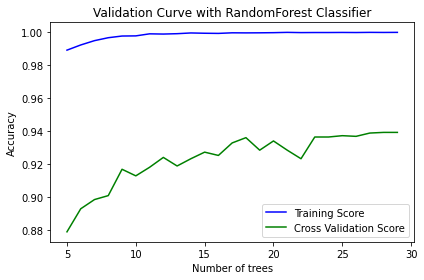

In [95]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with RandomForest Classifier")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

Using metric precision and model RandomForestClassifier(n_estimators=5)
Using metric precision and model RandomForestClassifier(n_estimators=6)
Using metric precision and model RandomForestClassifier(n_estimators=7)
Using metric precision and model RandomForestClassifier(n_estimators=8)
Using metric precision and model RandomForestClassifier(n_estimators=9)
Using metric precision and model RandomForestClassifier(n_estimators=10)
Using metric precision and model RandomForestClassifier(n_estimators=11)
Using metric precision and model RandomForestClassifier(n_estimators=12)
Using metric precision and model RandomForestClassifier(n_estimators=13)
Using metric precision and model RandomForestClassifier(n_estimators=14)
Using metric precision and model RandomForestClassifier(n_estimators=15)
Using metric precision and model RandomForestClassifier(n_estimators=16)
Using metric precision and model RandomForestClassifier(n_estimators=17)
Using metric precision and model RandomForestClassifier(

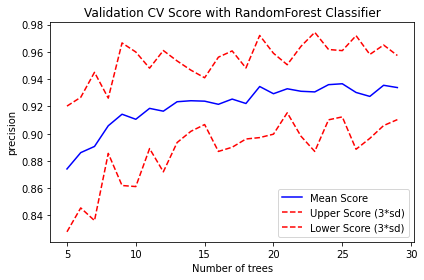

In [96]:
# Opció 2 Fes servir aquesta en comptes de la Validation Curve (mitjancant ara el cv score)
# Assumim aquí que els valors predits en funció del nombre d'estimadors segueixen una distribució normal.
means, std = list(), list()
parameter_range = np.arange(5, 30, 1)
for estimator in parameter_range:
    model = RandomForestClassifier(n_estimators=estimator)
    mean_score, std_score = eval_and_plot_cv_score(model, X_train, y_train, 'precision', folds = 5, 
                       response='classification')
    means.extend([mean_score]), std.extend([std_score]) 

upper, lower = [means[i] + 3*(std[i]) for i in range(len(means))], [means[i] - 3*(std[i]) for i in range(len(means))]

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, means, label = "Mean Score", color = 'b')
plt.plot(parameter_range, upper, label = "Upper Score (3*sd)", color = 'r', linestyle='--')
plt.plot(parameter_range, lower, label = "Lower Score (3*sd)", color = 'r', linestyle='--')
 
# Creating the plot
plt.title("Validation CV Score with RandomForest Classifier")
plt.xlabel("Number of trees")
plt.ylabel("precision")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Incrementa indefinidament la precisió si augmenta el nombre d'arbres combinats o es satura a una precisió limit? Per què?
</div>

S'observa un comportament creixent en la métrica. En quant al conjunt de train, el model es satura ràpidament al voltant del valor màxim. En quant al conjunt de cross validació,
sobserva un creixement i, a mesura que s'augmenta el nombre de classificadors, la métrica
es satura (tot i que per estar-ne segurs serà necessari augmentar el nombre de classificadors)

### 2.1.3. *Boosting*

En el sistema de Boosting es combinen varis classificadors dèbils seqüencialment, i en cadascun d'ells es dona més pes a les dades que han sigut erròniament classificades en les combinacions anteriors, perquè es concentri així en els casos més difícils de resoldre.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>

Evalua la precisió d'un <i>gradient boosting</i> amb profunditat màxima de 5 nivells i 20 etapes de <i>boosting</i> aplicant validació creuada sobre el conjunt de dades de train.

A continuació, entrena el mateix model sobre el conjunt de train, calcula i guarda les prediccions sobre el conjunt de test i calcula la precisió en el conjunt de test.
    
<u>Suggerència</u>: utilitzar el mòdul *GradientBoostingClassifier* de *sklearn*. Para aprendre a utilitzar aquest mòdul recomanem el següent enllaç:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

In [ ]:
model = GradientBoostingClassifier(max_depth=5, n_estimators=20)
evaluate_model_cross_validation("Gradient Boosting Classifier", 
                                model, X_train, y_train, folds = 5,
                               response='classification') # Quite slow increase folds if desired


Evaluating precision:

precision Scores are:
 [0.92586703 0.91133264 0.94837251 0.91470459 0.91685106]
>Gradient Boosting Classifier - training - precision: 0.923 (+/-0.013)

Evaluating recall:



In [ ]:
%time
gbc = GradientBoostingClassifier(max_depth=5, n_estimators=20)
gbc.fit(X_train_sc, y_train)

In [ ]:
# Opció 2. Esborra el que hi ha a dalt i utilitza aquesta funcion en comptes
gbc, _ = model_trainer(GradientBoostingClassifier(max_depth=5, n_estimators=20),
                       X_train_sc, y_train)

In [ ]:
predicted = gbc.predict(X_test_sc)

In [ ]:
from sklearn.metrics import precision_score
print("precision", precision_score(y_test, predicted, average='weighted'))
print("accuracy score", accuracy_score(y_test, predicted))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> Han millorat els resultats respecte a un simple arbre de decisió? Era d'esperar?
</div>

Si, han millorat degut a la metodología emprada per les técniques de boosting. El que busquen
es millorar la capacitat predictiva del model ponderant les prediccions erronies amb un pes
major que les predicciones acertades. Tot i aixó en aquests models s'ha de vigilar amb la posibilitat de produir overfitting.

## 2.2. Combinación seqüencial de classificadors base diferents

Per poder fer combinació seqüencial de models, necessitem tenir varis models diferents entrenats.

En el notre cas, ja tenim un arbre de decisió, el *random forest* i el *gradient boosting*. Anem a entrenar un parell de models més.

### 2.2.1 Classificadors adicionals

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong>
<br><br>
    
Entrena un <i>k-neighbors</i> amb 2 veïns sobre el conjunt de dades de train, calcula i guarda les prediccions sobre el conjunt de test i calcula la precisió en el conjunt de test.

Entrena un SVM (Suport vector machines) amb gamma = 0.07 sobre el conjunt de dades de train, calcula i guarda les prediccions sobre el conjunt de test i calcula la precisió en el conjunt de test.
</div>  

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
# SVM
svc = SVC(gamma=0.07)

In [ ]:
# Train models
knn.fit(X_train_sc, y_train)
svc.fit(X_train_sc, y_train)

In [ ]:
# Predict on test set and retrieve the precision
predicted_knn = knn.predict(X_test_sc)
predicted_svc = svc.predict(X_test_sc)

In [ ]:
# Metrics
# KNN
from sklearn.metrics import precision_score
print("KNN Results on test data")
print("precision", precision_score(y_test, predicted_knn, average='weighted'))
print("accuracy score", accuracy_score(y_test, predicted))
# SVC
from sklearn.metrics import precision_score
print("SVC Results on test data")
print("precision", precision_score(y_test, predicted_svc, average='weighted'))
print("accuracy score", accuracy_score(y_test, predicted))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisis:</strong> comenta els resultats.
</div>

In [ ]:
El KNN obté generalment métriques més altes que el SVC.

### 2.2.2 *Stacking*

Un classificador de stacking utilitza com a atributs les prediccions fetes per altres classificadors en comptes de les dades originals d'entrada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong>
<br><br>
    
Construeix un classificador de <i>stacking</i> utilitzant un <i>Gradient Boosting</i> (amb profunditat màxima de 5 nivells i 20 etapes de <i>boosting</i>) que utilitzi com a atributs les prediccions fetes en el conjunt de test pels algorismes: 
    
- arbre de decisió
- random forest
- gradient boosting
- knn
- svm 
 
Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test (en aquest cas no tenim conjunt de train, per aquest motiu es fa directament cross-validation sobre test).

<u>Suggerència</u>: utilitzar la función column_stack de numpy per ajuntar totes las prediccions. Donat que les variables que utilitzarem ara com a predictors són categòriques, és preferible transformar-les en *dummies* (*one-hot-encoding*). Per apendre a utilitzar aquestes funcions us recomanem els següents enllaços:
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
</div>

In [ ]:
# X_train has to be scaled
def build_train(model_dict, X_train, y_train, X_test, append_original=False):
    list_results = list()
    # creating instance of labelencoder
    onehot_encoder = OneHotEncoder(sparse=False)
    for model in model_dict:
        print(f"Running model {model}")
        m = model_dict[model]
        m.fit(X_train, y_train)
        predicted = m.predict(X_test).reshape(-1, 1)
        # print(onehot_encoder.fit_transform(predicted))
        list_results.append(onehot_encoder.fit_transform(predicted))
    
    if append_original:
        list_results.append(X_test)
    
    return np.column_stack(list_results)
        

In [ ]:
models = {
    'DT': DecisionTreeClassifier(max_depth=5),
    'RF': RandomForestClassifier(max_depth=5, n_jobs=-1, n_estimators=20),
    'GB': GradientBoostingClassifier(max_depth=5, n_estimators=20),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs=-1),
    'SVC': SVC(gamma=0.07)
}

In [ ]:
%time
prediction_array = build_train(models, X_train_sc, y_train, X_test_sc)

In [ ]:
print(prediction_array.shape)

In [ ]:
%time
f_est = GradientBoostingClassifier(max_depth=5, n_estimators=20)
evaluate_model_cross_validation("Gradient Boosting Classifier", f_est, prediction_array, y_test, folds = 5,
                               response='classification')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Anàlisis:</strong> Has aconseguit millorar la precisió gràcies al <i>stacking</i>? Comenta els resultats.
</div>

Tot i que resulta una mica complex comparar els resultats obtinguts en les anteriors etapes
amb els obtinguts mitjancant l'ús de la técnica Stacking, es pot concloure que els resultats milloren
substancialment. Al utilitzar técniques que fan servir una metodología una mica diferent (exemple
arbres vs vectors suport o veins més propers)

### 2.2.3. *Cascading*

El cas del cascading és similar al del stacking però utilitzant no només les prediccions parcials dels classificadors base, sinó també les dades originals.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementació:</strong>
<br><br>
    
Construeix un classificador de <i>cascading</i> utilitzant un <i>Gradient Boosting</i> (amb profunditat màxima de 5 nivells i 20 etapes de <i>boosting</i>) que utilitzi com atributs les prediccions obtingudes amb els models anteriors en el conjunt de test (igual que amb el <i>stacking</i>), i també les variables originals. 
    
Calcula la precisió del model resultant amb *cross-validation* en el conjunt de test.

<u>Suggerència</u>: Utilitza el mateix conjunt de dades que a l'exercici anterior però afegeix X_test.
</div>

In [ ]:
%time
prediction_cascading = build_train(models, X_train_sc, y_train, X_test_sc, append_original=True)

In [ ]:
%time
print(prediction_cascading.shape)

In [ ]:
%time
f_est = GradientBoostingClassifier(max_depth=5, n_estimators=20)
evaluate_model_cross_validation("Gradient Boosting Classifier", f_est, prediction_cascading, y_test, 
                                folds = 5, response='classification')

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Anàlisis:</strong> Has aconseguit millorar la precisió gràcies al <i>cascading</i>? Comenta els resultats.
</div>

Amb el cascading els resultats han millorat degut al augment considerable de les variables
explicatives. Fent servir un model basat en Stacking amb 5 models, el nombre de variables 
utilitzat era de 25 (5 models * 5 columnes amb els encodings corresponents). Ara en canvi
fem servir una matriu composada per 25 columnes + la dimensió del conjunt de variables emprades (784 variables). En cas de fer un model que s'utilitzi en un entorn de producció sería mes recomanable utilitzar la técnica d'Stacking degut al menor temps de computació.